In [1]:
import os
import cv2
import numpy as np
import h5py
import matplotlib.pyplot as plt
from tensorflow.keras.layers import InputLayer, Dense, Dropout, Conv2D, MaxPooling2D, Flatten, AveragePooling2D
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.metrics import  confusion_matrix,precision_score,accuracy_score,recall_score,ConfusionMatrixDisplay
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Nadam
import tensorflow as tf
import pandas as pd

In [2]:
URL="./Videos"


In [3]:
metricas={"precision":[],"recall":[]}

## Funciones definidas

In [4]:
def obtenerDatos(archivo):
   data=h5py.File(archivo)
   return data["X"][:],data["Y"][:] 

In [5]:
def obtener_etiquetas(url):
    labels=[]
    for index,carpeta in enumerate(os.listdir(str(url))):
        labels.append(carpeta)
    return labels

In [ ]:
def normalizar(X):
    X_normalizado = X.copy()
    for canal in range(X.shape[2]):  
        X_normalizado[:, :, canal] = (X[:, :, canal] - X[:, :, canal].min()) / (X[:, :, canal].max() - X    [:, :, canal].min())
    return X_normalizado

In [7]:
def redimensionarData(X,ancho,largo,num_canales):
    imagenes=[]
    for imagen in X:
        img=imagen
        img=cv2.resize(img, (ancho, largo), interpolation=cv2.INTER_AREA)
        if(num_canales==1):
            img=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
            img = np.expand_dims(img, axis=-1) 

        imagenes.append(img)
    return np.array(imagenes)


In [8]:
def plot_image(image):
    plt.imshow(image, cmap = "gray", interpolation = "nearest")
    plt.axis("off")

## Cargamos los datos

In [9]:
X_train,y_train=obtenerDatos("./data/datos_train_color.h5")


In [10]:
X_test,y_test=obtenerDatos("./data/datos_test_color.h5")


In [11]:
X_train.shape

(2400, 200, 200, 3)

In [12]:
y_train.shape

(2400,)

In [13]:
X_test.shape

(800, 200, 200, 3)

In [14]:
y_test.shape

(800,)

## Visualizamos la data

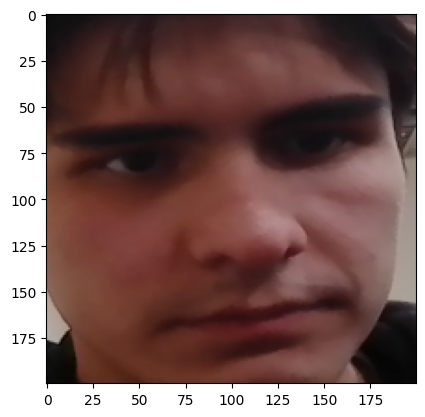

In [15]:
plt.imshow(X_train[1202])

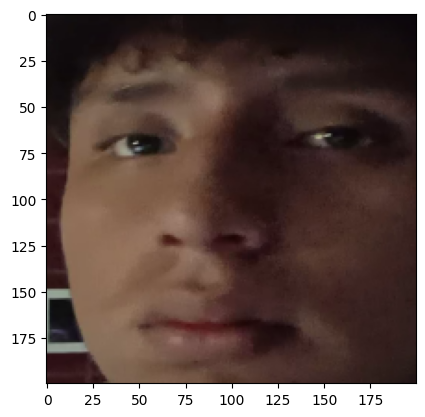

In [16]:
plt.imshow(X_train[500])

In [17]:
labels=[]

In [18]:
labels=['Agus', 'Ale', 'Noni', 'Sebas']

In [19]:
labels

['Agus', 'Ale', 'Noni', 'Sebas']

## Modelo Generico

In [20]:
class ModeloPersonalizado:
    def __init__(self, input_dim, output_dim):
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.modelo = None
        self.historial = None
        self.predicciones = None
        self.matriz_confusion = None

    def construir_modelo(self, configuracion):
        self.modelo = Sequential()
        self.modelo.add(InputLayer(input_shape=self.input_dim))

        # agregamos las capas convolucionales
        for capa in configuracion["capas_convolucionales"]:
            self.modelo.add(Conv2D(filters=capa["neuronas"], kernel_size=capa["kernel_size"], activation=capa["activation"]))
            if "max_pooling" in capa:
                self.modelo.add(MaxPooling2D(pool_size=capa["max_pooling"]))
            elif  "avg_pooling" in capa:
                self.modelo.add(AveragePooling2D(pool_size=capa["avg_pooling"]))

        self.modelo.add(Flatten())

        # agregamos capas densas
        for capa in configuracion["capas_ocultas"]:
            self.modelo.add(Dense(capa["neuronas"], activation=capa["activation"]))
            if "dropout" in capa and capa["dropout"] > 0:
                self.modelo.add(Dropout(capa["dropout"]))

        self.modelo.add(Dense(self.output_dim, activation="softmax"))

    def compilar_modelo(self, learning_rate):
        optimizer = Nadam(learning_rate=learning_rate)
        self.modelo.compile(
            optimizer=optimizer,
            loss="sparse_categorical_crossentropy",
            metrics=["accuracy"]
        )

    def entrenar_modelo(self, X_train, y_train, X_val, y_val, epochs, factor_reduccion, paciencia):
        """
        Un callback en Keras es un conjunto de funciones que puedes usar para personalizar y controlar el proceso de entrenamiento del modelo
        ReduceLROnPlateau es un callback en Keras que se utiliza para reducir la tasa de aprendizaje (learning rate)
        automáticamente si una métrica(val_loss) no mejora después de un número definido de épocas (patience).
        min_lr:El learning rate no se reducirá por debajo de este valor, lo que previene que se acerque a cero.
        lr_scheduler=planificador de la tasa de aprendizaje

        Todo este trabajo se hace poruqe la tasa de aprendizaje se encarga de enontrar el j mas pequeno para los thetas
        si este j o en nuestro caso el val_loss ya no baja mucho o de la nada se subio su valor que posiblemente estemos cerca al mejor
        j o val_loss posible para los tethas y nos conviende dar pasitos mas cortos en la tasa de aprendizaje cuidando de que no sea cero con 
        min_lr
        """
        lr_scheduler = ReduceLROnPlateau(
            monitor="val_loss",
            factor=factor_reduccion,
            patience=paciencia,
            verbose=1,
            min_lr=1e-6
        )

        self.historial = self.modelo.fit(
            X_train, 
            y_train, 
            epochs=epochs, 
            validation_data=(X_val, y_val), 
            callbacks=[lr_scheduler], 
            verbose=1
        )

    def evaluar_modelo(self, X_test, y_test, labels, configuracion):
        probabilidades = self.modelo.predict(X_test)
        self.predicciones = np.argmax(probabilidades, axis=1)

        #El macro average calcula la precisión y el recall de forma independiente para cada clase. Luego toma el promedio aritmético de esas métricas.
        precision = precision_score(y_test, self.predicciones, average="macro")
        recall = recall_score(y_test, self.predicciones, average="macro")

        self.matriz_confusion = confusion_matrix(y_test, self.predicciones)

        resultados = {
            "configuracion": configuracion,
            "precision": precision,
            "recall": recall,
            "historial": self.historial.history,
            "matriz_confusion": self.matriz_confusion
        }

        return resultados

## Configramos los modelos

In [21]:
configuraciones=[ 
    ## CNN BASICA
    {
       
        "input_dims":  (32,32,3),
        "capas_convolucionales":[
          {"neuronas":32,
           "kernel_size":(3, 3),
           "activation":"relu",
           "max_pooling":(2,2)
           },
           {"neuronas":64,
           "kernel_size":(3, 3),
           "activation":"relu",
           "max_pooling":(2,2)
           }
        ],
        "capas_ocultas": [{"neuronas": 128, "activation": "relu"}],
        "learning_rate": 0.001,
        "factor_reduccion": 0.1,
        "output": {"neuronas": 4, "activation": "softmax"}
    },
        {
       
        "input_dims":  (32,32,3),
        "capas_convolucionales":[
          {"neuronas":32,
           "kernel_size":(3, 3),
           "activation":"sigmoid",
           "max_pooling":(2,2)
           },
           {"neuronas":64,
           "kernel_size":(3, 3),
           "activation":"sigmoid",
           "max_pooling":(2,2)
           }
        ],
        "capas_ocultas": [{"neuronas": 128, "activation": "sigmoid"}],
        "learning_rate": 0.001,
        "factor_reduccion": 0.1,
        "output": {"neuronas": 4, "activation": "softmax"}
    },
    ## CNN Imagenes Grandes
    {
       
        "input_dims":  (128,128,3),
        "capas_convolucionales":[
          {"neuronas":64,
           "kernel_size":(7, 7),
           "activation":"relu",
           "max_pooling":(3,3)
           },
           {"neuronas":128,
           "kernel_size":(3, 3),
           "activation":"relu",
           },
          {"neuronas":256,
           "kernel_size":(3, 3),
           "activation":"relu",
           "max_pooling":(3,3)
           }
        ],
        "capas_ocultas": [{"neuronas": 512, "activation": "relu","dropout": 0.15}],
        "learning_rate": 0.001,
        "factor_reduccion": 0.1,
        "output": {"neuronas": 4, "activation": "softmax"}
    },
        {
       
        "input_dims":  (128,128,3),
        "capas_convolucionales":[
          {"neuronas":64,
           "kernel_size":(7, 7),
           "activation":"sigmoid",
           "max_pooling":(3,3)
           },
           {"neuronas":128,
           "kernel_size":(3, 3),
           "activation":"sigmoid",
           },
          {"neuronas":256,
           "kernel_size":(3, 3),
           "activation":"sigmoid",
           "max_pooling":(3,3)
           }
        ],
        "capas_ocultas": [{"neuronas": 512, "activation": "sigmoid","dropout": 0.15}],
        "learning_rate": 0.001,
        "factor_reduccion": 0.1,
        "output": {"neuronas": 4, "activation": "softmax"}
    },


    ## CNN Profunda
    {
       
        "input_dims":  (64,64,3),
        "capas_convolucionales":[
          {"neuronas":32,
           "kernel_size":(3, 3),
           "activation":"relu",
           },
            {"neuronas":64,
           "kernel_size":(3, 3),
           "activation":"relu",
            "max_pooling":(2,2)
           },

           {"neuronas":128,
           "kernel_size":(3, 3),
           "activation":"relu",
           },
            {"neuronas":256,
           "kernel_size":(3, 3),
           "activation":"relu",
            "max_pooling":(2,2)
           },
           {"neuronas":512,
           "kernel_size":(3, 3),
           "activation":"relu",
            "max_pooling":(2,2)
           }
        ],
        "capas_ocultas": [{"neuronas": 1024, "activation": "relu","dropout": 0.15}],
        "learning_rate": 0.001,
        "factor_reduccion": 0.1,
        "output": {"neuronas": 4, "activation": "softmax"}
    },
    {
       
        "input_dims":  (64,64,3),
        "capas_convolucionales":[
          {"neuronas":32,
           "kernel_size":(3, 3),
           "activation":"sigmoid",
           },
            {"neuronas":64,
           "kernel_size":(3, 3),
           "activation":"sigmoid",
            "max_pooling":(2,2)
           },

           {"neuronas":128,
           "kernel_size":(3, 3),
           "activation":"sigmoid",
           },
            {"neuronas":256,
           "kernel_size":(3, 3),
           "activation":"sigmoid",
            "max_pooling":(2,2)
           },
           {"neuronas":512,
           "kernel_size":(3, 3),
           "activation":"sigmoid",
            "max_pooling":(2,2)
           }
        ],
        "capas_ocultas": [{"neuronas": 1024, "activation": "sigmoid","dropout": 0.15}],
        "learning_rate": 0.001,
        "factor_reduccion": 0.1,
        "output": {"neuronas": 4, "activation": "softmax"}
    },


    ## CNN Imagenes Grandes sin DropOut
    {
       
        "input_dims":  (128,128,3),
        "capas_convolucionales":[
          {"neuronas":64,
           "kernel_size":(7, 7),
           "activation":"relu",
           "max_pooling":(3,3)
           },
           {"neuronas":128,
           "kernel_size":(3, 3),
           "activation":"relu",
           },
          {"neuronas":256,
           "kernel_size":(3, 3),
           "activation":"relu",
           "max_pooling":(3,3)
           }
        ],
        "capas_ocultas": [{"neuronas": 512, "activation": "relu"}],
        "learning_rate": 0.001,
        "factor_reduccion": 0.1,
        "output": {"neuronas": 4, "activation": "softmax"}
    },
    {
       
        "input_dims":  (128,128,3),
        "capas_convolucionales":[
          {"neuronas":64,
           "kernel_size":(7, 7),
           "activation":"sigmoid",
           "max_pooling":(3,3)
           },
           {"neuronas":128,
           "kernel_size":(3, 3),
           "activation":"sigmoid",
           },
          {"neuronas":256,
           "kernel_size":(3, 3),
           "activation":"sigmoid",
           "max_pooling":(3,3)
           }
        ],
        "capas_ocultas": [{"neuronas": 512, "activation": "sigmoid"}],
        "learning_rate": 0.001,
        "factor_reduccion": 0.1,
        "output": {"neuronas": 4, "activation": "softmax"}
    },


    ## CNN Profunda Sin Dropout
    {
       
        "input_dims":  (64,64,3),
        "capas_convolucionales":[
          {"neuronas":32,
           "kernel_size":(3, 3),
           "activation":"relu",
           },
            {"neuronas":64,
           "kernel_size":(3, 3),
           "activation":"relu",
            "max_pooling":(2,2)
           },

           {"neuronas":128,
           "kernel_size":(3, 3),
           "activation":"relu",
           },
            {"neuronas":256,
           "kernel_size":(3, 3),
           "activation":"relu",
            "max_pooling":(2,2)
           },
           {"neuronas":512,
           "kernel_size":(3, 3),
           "activation":"relu",
            "max_pooling":(2,2)
           }
        ],
        "capas_ocultas": [{"neuronas": 1024, "activation": "relu"}],
        "learning_rate": 0.001,
        "factor_reduccion": 0.1,
        "output": {"neuronas": 4, "activation": "softmax"}
    },
    {
       
        "input_dims":  (64,64,3),
        "capas_convolucionales":[
          {"neuronas":32,
           "kernel_size":(3, 3),
           "activation":"sigmoid",
           },
            {"neuronas":64,
           "kernel_size":(3, 3),
           "activation":"sigmoid",
            "max_pooling":(2,2)
           },

           {"neuronas":128,
           "kernel_size":(3, 3),
           "activation":"sigmoid",
           },
            {"neuronas":256,
           "kernel_size":(3, 3),
           "activation":"sigmoid",
            "max_pooling":(2,2)
           },
           {"neuronas":512,
           "kernel_size":(3, 3),
           "activation":"sigmoid",
            "max_pooling":(2,2)
           }
        ],
        "capas_ocultas": [{"neuronas": 1024, "activation": "sigmoid"}],
        "learning_rate": 0.001,
        "factor_reduccion": 0.1,
        "output": {"neuronas": 4, "activation": "softmax"}
    },


]

In [22]:

resultados_metricas = []

for idx, config in enumerate(configuraciones):
    print(f"Entrenando modelo {idx + 1}/{len(configuraciones)}...")
    input_dims=config["input_dims"]
    X_train_copia=X_train.copy()
    X_test_copia=X_test.copy()

    X_train_copia=redimensionarData(X_train_copia,*input_dims)
    X_test_copia=redimensionarData(X_test_copia,*input_dims)
    X_train_copia=normalizar(X_train_copia)
    X_test_copia=normalizar(X_test_copia)
    print(X_train_copia.shape)
    print(X_test_copia.shape)
    

    modelo = ModeloPersonalizado(input_dim=input_dims, output_dim=4)
    modelo.construir_modelo(config)
    modelo.compilar_modelo(learning_rate=config["learning_rate"])
    modelo.entrenar_modelo(
        X_train=X_train_copia,
        y_train=y_train,
        X_val=X_test_copia,
        y_val=y_test,
        epochs=15,
        factor_reduccion=config["factor_reduccion"],
        paciencia=5,
    )
    
    resultados = modelo.evaluar_modelo(
        X_test=X_test_copia,
        y_test=y_test,
        labels=labels,
        configuracion=config
    )
    resultados_metricas.append(resultados)

    print(f"Modelo {idx + 1} se acabo de entrenar y se guardo")

df_resultados = pd.DataFrame(resultados_metricas)


Entrenando modelo 1/10...
(2400, 32, 32, 3)
(800, 32, 32, 3)


C:\Users\Usuario\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - accuracy: 0.6661 - loss: 0.8049 - val_accuracy: 0.4338 - val_loss: 3.4021 - learning_rate: 0.0010
Epoch 2/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9976 - loss: 0.0115 - val_accuracy: 0.4538 - val_loss: 3.2926 - learning_rate: 0.0010
Epoch 3/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9990 - loss: 0.0072 - val_accuracy: 0.4613 - val_loss: 4.2848 - learning_rate: 0.0010
Epoch 4/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9979 - loss: 0.0057 - val_accuracy: 0.4613 - val_loss: 4.5329 - learning_rate: 0.0010
Epoch 5/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.0000 - loss: 0.0014 - val_accuracy: 0.4375 - val_loss: 4.0550 - learning_rate: 0.0010
Epoch 6/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9992 - loss: 0.0019 - val_accuracy: 0.4212 - val_loss: 2.6597 - learning_rate: 0.0010
Epoch 7/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 1.0000 - loss: 6.2893e-04 - va

C:\Users\Usuario\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.2389 - loss: 1.4893 - val_accuracy: 0.2438 - val_loss: 1.4047 - learning_rate: 0.0010
Epoch 2/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 82ms/step - accuracy: 0.5700 - loss: 1.0874 - val_accuracy: 0.6475 - val_loss: 2.2551 - learning_rate: 0.0010
Epoch 3/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.9284 - loss: 0.3299 - val_accuracy: 0.6900 - val_loss: 2.1355 - learning_rate: 0.0010
Epoch 4/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9874 - loss: 0.1295 - val_accuracy: 0.6837 - val_loss: 2.2419 - learning_rate: 0.0010
Epoch 5/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9970 - loss: 0.0623 - val_accuracy: 0.7412 - val_loss: 2.1287 - learning_rate: 0.0010
Epoch 6/15
74/75 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9952 - loss: 0.0394
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9952 - loss: 0.0393 - val_accuracy: 0.74

C:\Users\Usuario\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


(2400, 128, 128, 3)
(800, 128, 128, 3)


C:\Users\Usuario\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 107s 1s/step - accuracy: 0.5726 - loss: 1.2467 - val_accuracy: 0.4375 - val_loss: 4.3293 - learning_rate: 0.0010
Epoch 2/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 103s 1s/step - accuracy: 0.9978 - loss: 0.0065 - val_accuracy: 0.4387 - val_loss: 4.2779 - learning_rate: 0.0010
Epoch 3/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 94s 1s/step - accuracy: 0.9987 - loss: 0.0040 - val_accuracy: 0.4487 - val_loss: 5.3244 - learning_rate: 0.0010
Epoch 4/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 95s 1s/step - accuracy: 0.9988 - loss: 0.0021 - val_accuracy: 0.4550 - val_loss: 6.7099 - learning_rate: 0.0010
Epoch 5/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 98s 1s/step - accuracy: 0.9997 - loss: 7.9133e-04 - val_accuracy: 0.4363 - val_loss: 5.0097 - learning_rate: 0.0010
Epoch 6/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 92s 1s/step - accuracy: 0.9992 - loss: 0.0022 - val_accuracy: 0.4888 - val_loss: 5.6691 - learning_rate: 0.0010
Epoch 7/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9653 - loss: 0.1687
Epoch 7: Re

C:\Users\Usuario\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 106s 1s/step - accuracy: 0.2532 - loss: 3.7154 - val_accuracy: 0.2500 - val_loss: 1.3984 - learning_rate: 0.0010
Epoch 2/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 103s 1s/step - accuracy: 0.2433 - loss: 1.4490 - val_accuracy: 0.2500 - val_loss: 1.3967 - learning_rate: 0.0010
Epoch 3/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 95s 1s/step - accuracy: 0.2530 - loss: 1.4323 - val_accuracy: 0.2500 - val_loss: 1.3884 - learning_rate: 0.0010
Epoch 4/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 103s 1s/step - accuracy: 0.2460 - loss: 1.4422 - val_accuracy: 0.2500 - val_loss: 1.3963 - learning_rate: 0.0010
Epoch 5/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 95s 1s/step - accuracy: 0.2308 - loss: 1.4476 - val_accuracy: 0.2500 - val_loss: 1.3923 - learning_rate: 0.0010
Epoch 6/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 103s 1s/step - accuracy: 0.2500 - loss: 1.4326 - val_accuracy: 0.2500 - val_loss: 1.3960 - learning_rate: 0.0010
Epoch 7/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 101s 1s/step - accuracy: 0.2690 - loss: 1.4216 - val_accur

C:\Users\Usuario\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Modelo 4 se acabo de entrenar y se guardo
Entrenando modelo 5/10...
(2400, 64, 64, 3)
(800, 64, 64, 3)


C:\Users\Usuario\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 84s 1s/step - accuracy: 0.5247 - loss: 1.0738 - val_accuracy: 0.3512 - val_loss: 4.4469 - learning_rate: 0.0010
Epoch 2/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 72s 971ms/step - accuracy: 0.9935 - loss: 0.0217 - val_accuracy: 0.4387 - val_loss: 4.3553 - learning_rate: 0.0010
Epoch 3/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 73s 978ms/step - accuracy: 0.9940 - loss: 0.0149 - val_accuracy: 0.4650 - val_loss: 5.1354 - learning_rate: 0.0010
Epoch 4/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 72s 969ms/step - accuracy: 0.9992 - loss: 0.0050 - val_accuracy: 0.3350 - val_loss: 5.8073 - learning_rate: 0.0010
Epoch 5/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 71s 956ms/step - accuracy: 1.0000 - loss: 2.6178e-04 - val_accuracy: 0.4487 - val_loss: 7.4842 - learning_rate: 0.0010
Epoch 6/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 72s 964ms/step - accuracy: 1.0000 - loss: 6.8223e-06 - val_accuracy: 0.4563 - val_loss: 8.2486 - learning_rate: 0.0010
Epoch 7/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 890ms/step - accuracy: 1.0000 - loss

C:\Users\Usuario\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


(2400, 64, 64, 3)
(800, 64, 64, 3)


C:\Users\Usuario\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 84s 972ms/step - accuracy: 0.2600 - loss: 3.1420 - val_accuracy: 0.2500 - val_loss: 1.3963 - learning_rate: 0.0010
Epoch 2/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 74s 991ms/step - accuracy: 0.2594 - loss: 1.4190 - val_accuracy: 0.2500 - val_loss: 1.3963 - learning_rate: 0.0010
Epoch 3/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.2295 - loss: 1.4420 - val_accuracy: 0.2500 - val_loss: 1.4095 - learning_rate: 0.0010
Epoch 4/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 73s 981ms/step - accuracy: 0.2670 - loss: 1.4241 - val_accuracy: 0.2500 - val_loss: 1.3965 - learning_rate: 0.0010
Epoch 5/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 73s 978ms/step - accuracy: 0.2628 - loss: 1.4193 - val_accuracy: 0.2500 - val_loss: 1.3917 - learning_rate: 0.0010
Epoch 6/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 75s 1s/step - accuracy: 0.2371 - loss: 1.4269 - val_accuracy: 0.2500 - val_loss: 1.3881 - learning_rate: 0.0010
Epoch 7/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 78s 1s/step - accuracy: 0.2589 - loss: 1.4259 - va

C:\Users\Usuario\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Modelo 6 se acabo de entrenar y se guardo
Entrenando modelo 7/10...
(2400, 128, 128, 3)
(800, 128, 128, 3)


C:\Users\Usuario\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 104s 1s/step - accuracy: 0.5707 - loss: 1.0728 - val_accuracy: 0.4137 - val_loss: 4.0066 - learning_rate: 0.0010
Epoch 2/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 93s 1s/step - accuracy: 0.9970 - loss: 0.0096 - val_accuracy: 0.4863 - val_loss: 3.3261 - learning_rate: 0.0010
Epoch 3/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 100s 1s/step - accuracy: 0.9962 - loss: 0.0134 - val_accuracy: 0.4950 - val_loss: 6.9420 - learning_rate: 0.0010
Epoch 4/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 93s 1s/step - accuracy: 0.9396 - loss: 0.5319 - val_accuracy: 0.4712 - val_loss: 6.8991 - learning_rate: 0.0010
Epoch 5/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 93s 1s/step - accuracy: 0.9979 - loss: 0.0119 - val_accuracy: 0.4387 - val_loss: 8.2713 - learning_rate: 0.0010
Epoch 6/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 100s 1s/step - accuracy: 0.9997 - loss: 0.0012 - val_accuracy: 0.4375 - val_loss: 8.2128 - learning_rate: 0.0010
Epoch 7/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 1.8001e-04
Epoch 7: R

C:\Users\Usuario\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 105s 1s/step - accuracy: 0.2537 - loss: 5.3160 - val_accuracy: 0.2500 - val_loss: 1.3906 - learning_rate: 0.0010
Epoch 2/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 101s 1s/step - accuracy: 0.2534 - loss: 1.3919 - val_accuracy: 0.2500 - val_loss: 1.3867 - learning_rate: 0.0010
Epoch 3/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 96s 1s/step - accuracy: 0.2584 - loss: 1.3932 - val_accuracy: 0.2500 - val_loss: 1.3902 - learning_rate: 0.0010
Epoch 4/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 103s 1s/step - accuracy: 0.2390 - loss: 1.3930 - val_accuracy: 0.2500 - val_loss: 1.4007 - learning_rate: 0.0010
Epoch 5/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 104s 1s/step - accuracy: 0.2461 - loss: 1.4001 - val_accuracy: 0.2500 - val_loss: 1.3914 - learning_rate: 0.0010
Epoch 6/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 103s 1s/step - accuracy: 0.2433 - loss: 1.3940 - val_accuracy: 0.2500 - val_loss: 1.3990 - learning_rate: 0.0010
Epoch 7/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2460 - loss: 1.3999
Epoch 7: Red

C:\Users\Usuario\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


(2400, 64, 64, 3)
(800, 64, 64, 3)


C:\Users\Usuario\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 83s 960ms/step - accuracy: 0.4921 - loss: 1.0785 - val_accuracy: 0.4512 - val_loss: 4.2255 - learning_rate: 0.0010
Epoch 2/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 72s 965ms/step - accuracy: 0.9980 - loss: 0.0080 - val_accuracy: 0.6100 - val_loss: 2.7913 - learning_rate: 0.0010
Epoch 3/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 72s 960ms/step - accuracy: 0.9969 - loss: 0.0215 - val_accuracy: 0.4775 - val_loss: 9.3919 - learning_rate: 0.0010
Epoch 4/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 79s 1s/step - accuracy: 0.9937 - loss: 0.0756 - val_accuracy: 0.4575 - val_loss: 1.9469 - learning_rate: 0.0010
Epoch 5/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 72s 969ms/step - accuracy: 0.9956 - loss: 0.0098 - val_accuracy: 0.4900 - val_loss: 4.2204 - learning_rate: 0.0010
Epoch 6/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 72s 960ms/step - accuracy: 0.9997 - loss: 8.6026e-04 - val_accuracy: 0.4863 - val_loss: 4.9830 - learning_rate: 0.0010
Epoch 7/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 72s 961ms/step - accuracy: 1.0000 - loss: 1

C:\Users\Usuario\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


(2400, 64, 64, 3)
(800, 64, 64, 3)


C:\Users\Usuario\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 83s 974ms/step - accuracy: 0.2648 - loss: 2.9961 - val_accuracy: 0.2500 - val_loss: 1.3873 - learning_rate: 0.0010
Epoch 2/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 73s 984ms/step - accuracy: 0.2604 - loss: 1.4051 - val_accuracy: 0.2500 - val_loss: 1.3962 - learning_rate: 0.0010
Epoch 3/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 79s 1s/step - accuracy: 0.2312 - loss: 1.4072 - val_accuracy: 0.2500 - val_loss: 1.4102 - learning_rate: 0.0010
Epoch 4/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 73s 964ms/step - accuracy: 0.2598 - loss: 1.4096 - val_accuracy: 0.2500 - val_loss: 1.3908 - learning_rate: 0.0010
Epoch 5/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 73s 976ms/step - accuracy: 0.2419 - loss: 1.4046 - val_accuracy: 0.2500 - val_loss: 1.4195 - learning_rate: 0.0010
Epoch 6/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 938ms/step - accuracy: 0.2559 - loss: 1.4027
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
75/75 ━━━━━━━━━━━━━━━━━━━━ 76s 1s/step - accuracy: 0.2559 - loss: 1.4028 - 

C:\Users\Usuario\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Modelo 1:
----------------------------------------
Configuración del modelo:
Capas Ocultas:
  Capa 1: 128 neuronas, activación='relu', dropout=0
Learning Rate: 0.001
Factor de Reducción: 0.1
Salida: 4 neuronas, activación='softmax'

Métricas del modelo:
Precisión: 0.2950
Recall: 0.4575

Graficando historial de entrenamiento...


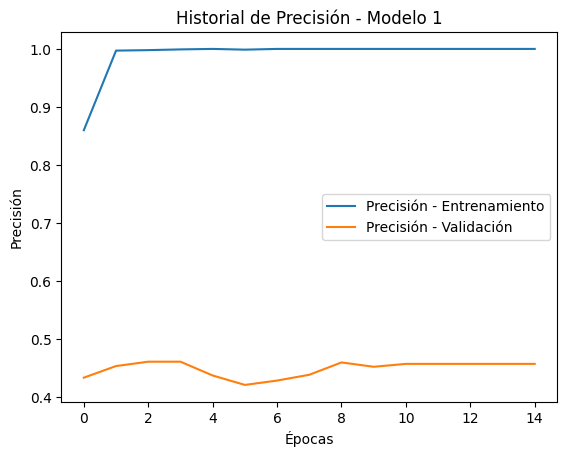

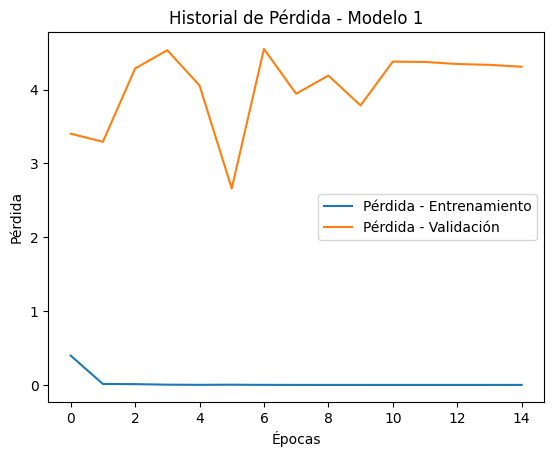


Matriz de Confusión:


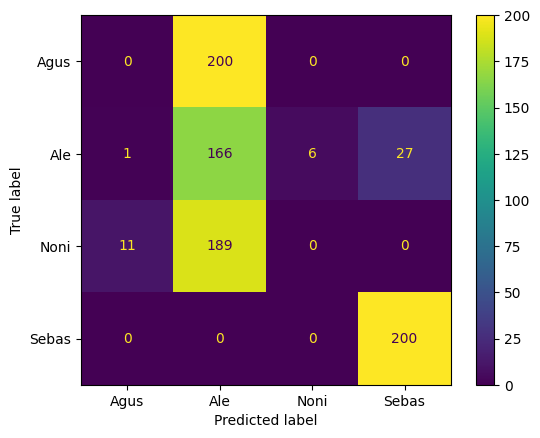



Modelo 2:
----------------------------------------
Configuración del modelo:
Capas Ocultas:
  Capa 1: 128 neuronas, activación='sigmoid', dropout=0
Learning Rate: 0.001
Factor de Reducción: 0.1
Salida: 4 neuronas, activación='softmax'

Métricas del modelo:
Precisión: 0.6222
Recall: 0.7438

Graficando historial de entrenamiento...


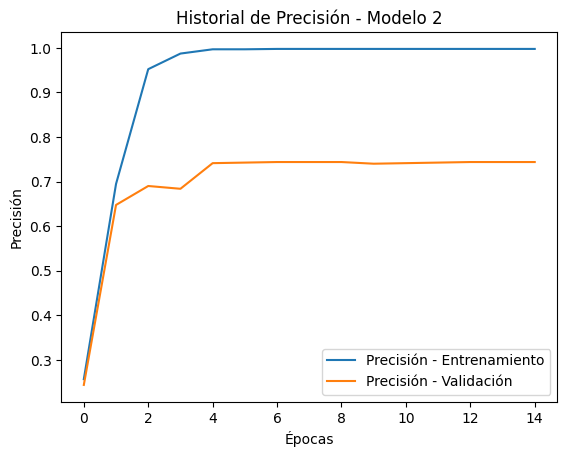

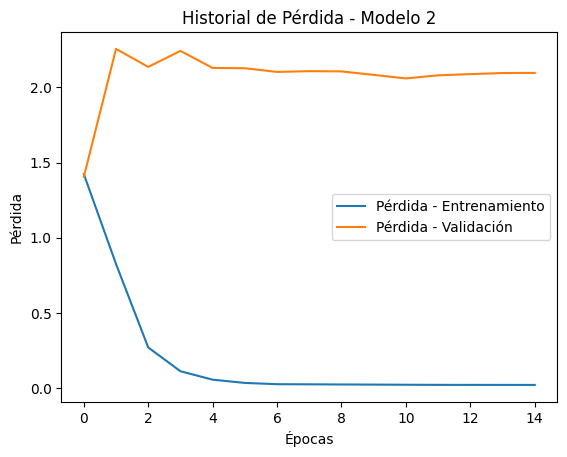


Matriz de Confusión:


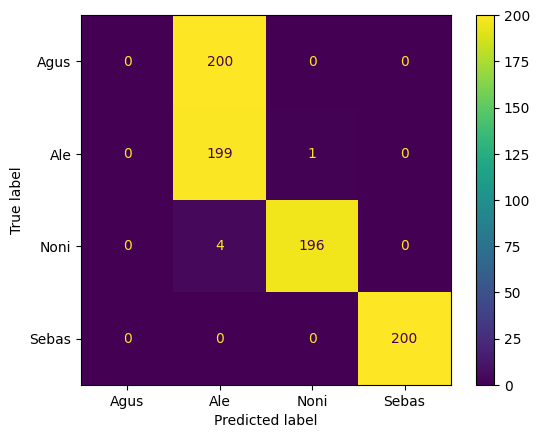



Modelo 3:
----------------------------------------
Configuración del modelo:
Capas Ocultas:
  Capa 1: 512 neuronas, activación='relu', dropout=0.15
Learning Rate: 0.001
Factor de Reducción: 0.1
Salida: 4 neuronas, activación='softmax'

Métricas del modelo:
Precisión: 0.3318
Recall: 0.4387

Graficando historial de entrenamiento...


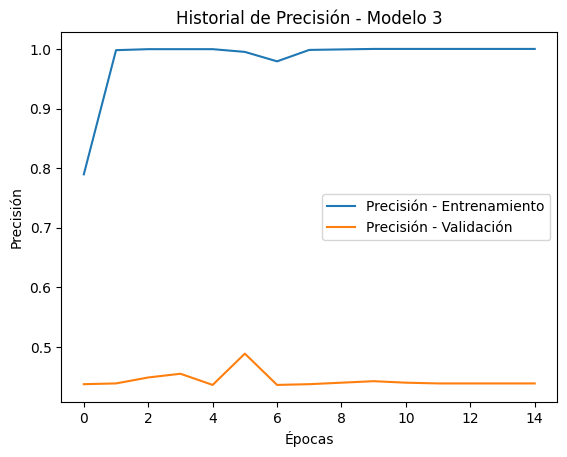

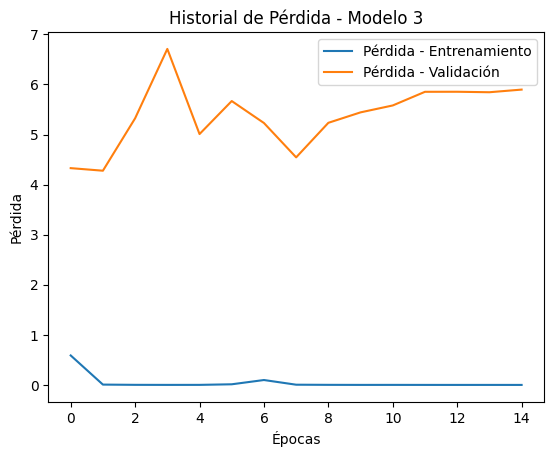


Matriz de Confusión:


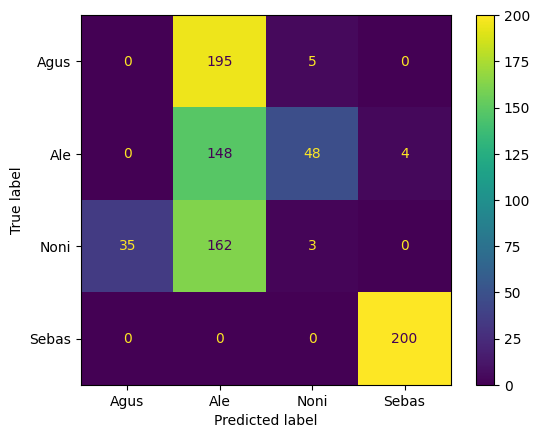



Modelo 4:
----------------------------------------
Configuración del modelo:
Capas Ocultas:
  Capa 1: 512 neuronas, activación='sigmoid', dropout=0.15
Learning Rate: 0.001
Factor de Reducción: 0.1
Salida: 4 neuronas, activación='softmax'

Métricas del modelo:
Precisión: 0.0625
Recall: 0.2500

Graficando historial de entrenamiento...


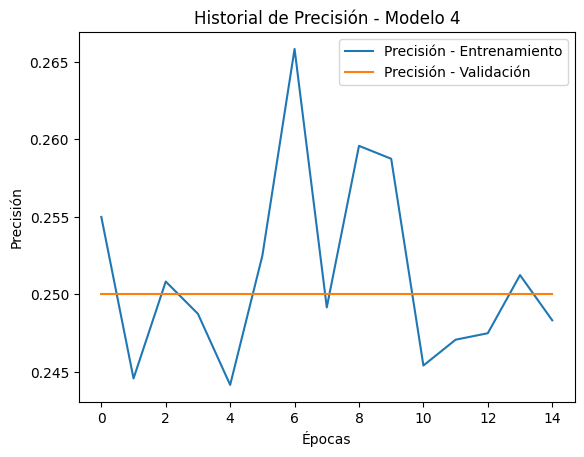

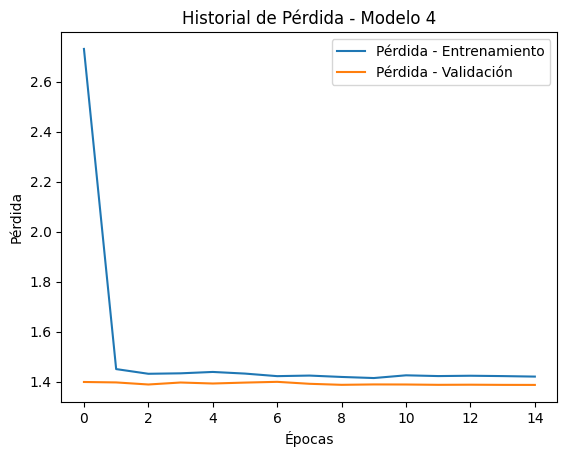


Matriz de Confusión:


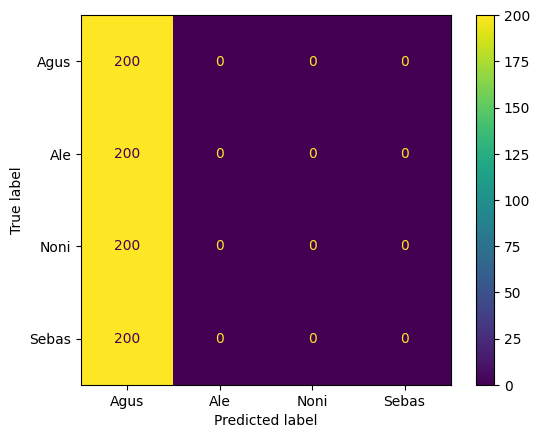



Modelo 5:
----------------------------------------
Configuración del modelo:
Capas Ocultas:
  Capa 1: 1024 neuronas, activación='relu', dropout=0.15
Learning Rate: 0.001
Factor de Reducción: 0.1
Salida: 4 neuronas, activación='softmax'

Métricas del modelo:
Precisión: 0.2945
Recall: 0.4575

Graficando historial de entrenamiento...


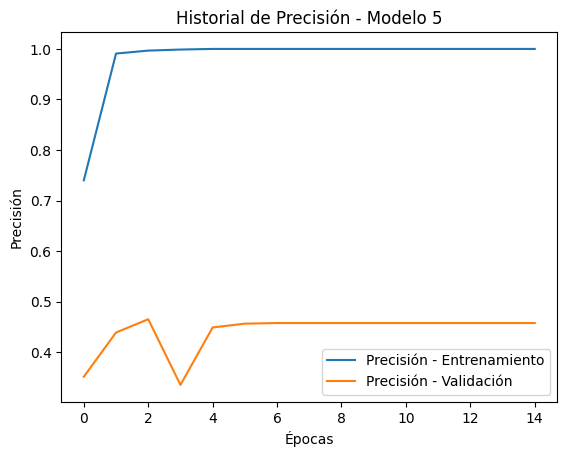

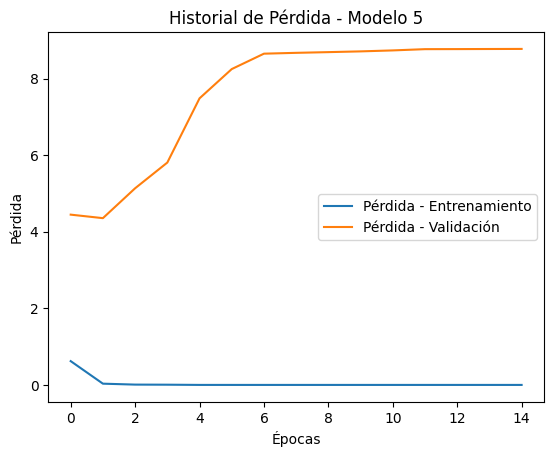


Matriz de Confusión:


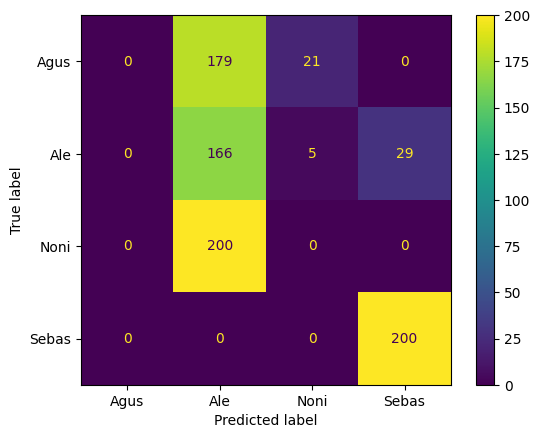



Modelo 6:
----------------------------------------
Configuración del modelo:
Capas Ocultas:
  Capa 1: 1024 neuronas, activación='sigmoid', dropout=0.15
Learning Rate: 0.001
Factor de Reducción: 0.1
Salida: 4 neuronas, activación='softmax'

Métricas del modelo:
Precisión: 0.0625
Recall: 0.2500

Graficando historial de entrenamiento...


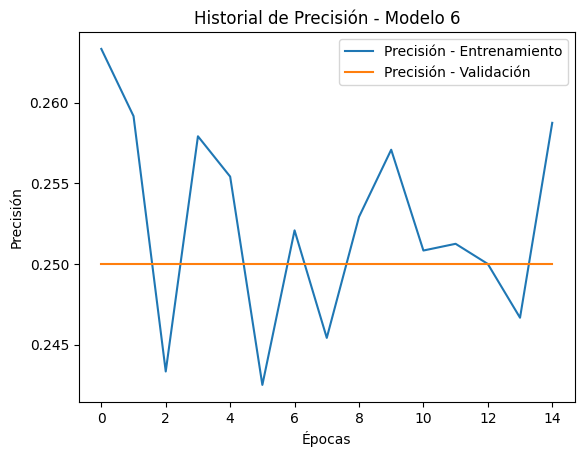

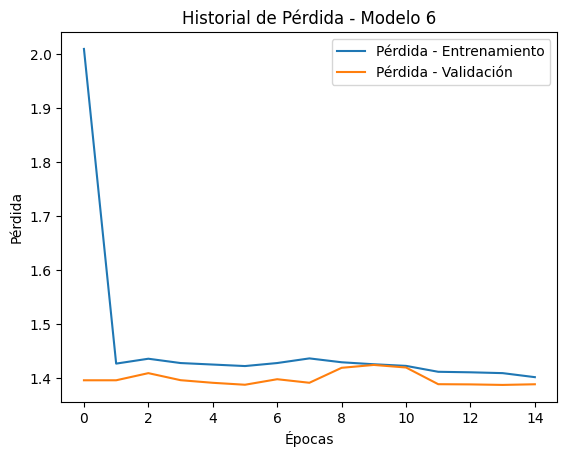


Matriz de Confusión:


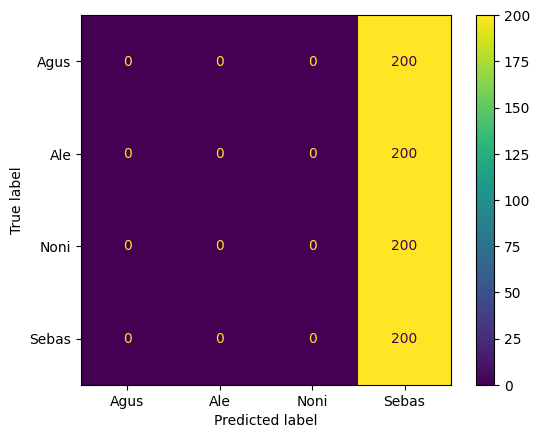



Modelo 7:
----------------------------------------
Configuración del modelo:
Capas Ocultas:
  Capa 1: 512 neuronas, activación='relu', dropout=0
Learning Rate: 0.001
Factor de Reducción: 0.1
Salida: 4 neuronas, activación='softmax'

Métricas del modelo:
Precisión: 0.2922
Recall: 0.4313

Graficando historial de entrenamiento...


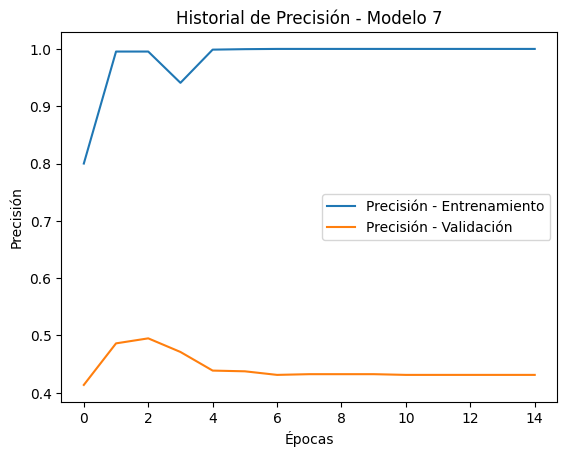

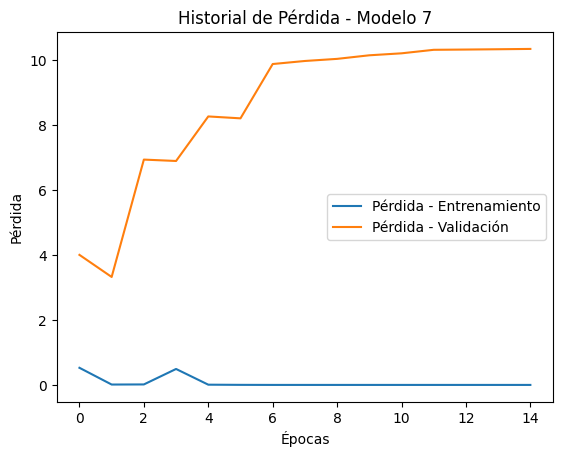


Matriz de Confusión:


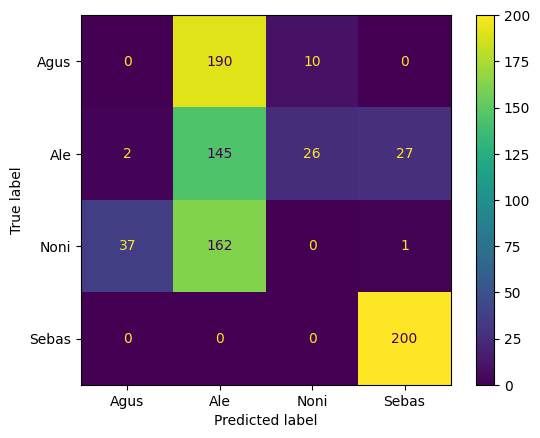



Modelo 8:
----------------------------------------
Configuración del modelo:
Capas Ocultas:
  Capa 1: 512 neuronas, activación='sigmoid', dropout=0
Learning Rate: 0.001
Factor de Reducción: 0.1
Salida: 4 neuronas, activación='softmax'

Métricas del modelo:
Precisión: 0.0625
Recall: 0.2500

Graficando historial de entrenamiento...


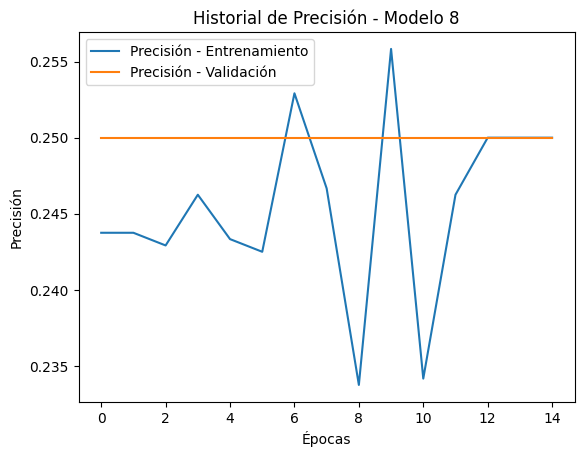

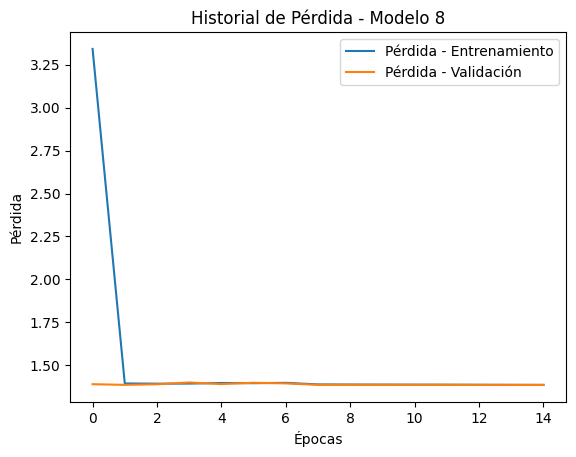


Matriz de Confusión:


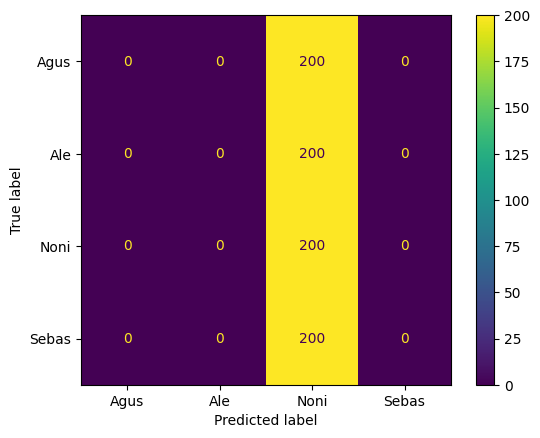



Modelo 9:
----------------------------------------
Configuración del modelo:
Capas Ocultas:
  Capa 1: 1024 neuronas, activación='relu', dropout=0
Learning Rate: 0.001
Factor de Reducción: 0.1
Salida: 4 neuronas, activación='softmax'

Métricas del modelo:
Precisión: 0.3087
Recall: 0.4800

Graficando historial de entrenamiento...


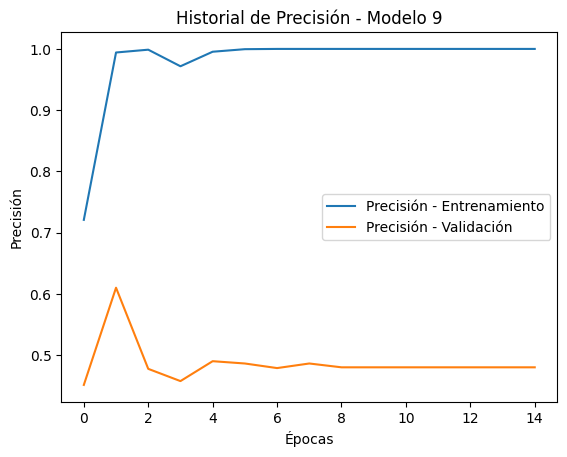

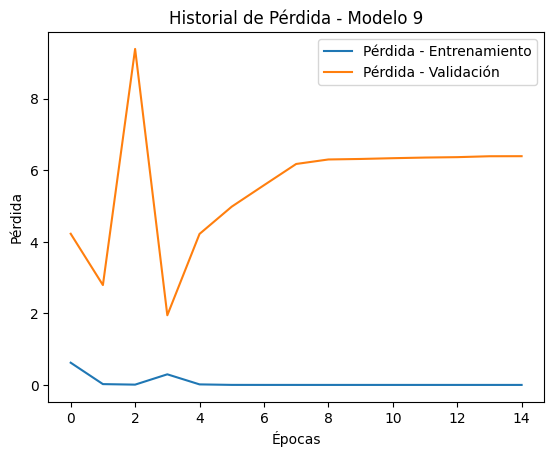


Matriz de Confusión:


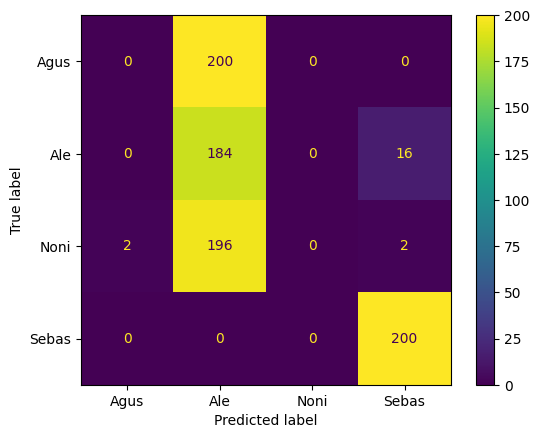



Modelo 10:
----------------------------------------
Configuración del modelo:
Capas Ocultas:
  Capa 1: 1024 neuronas, activación='sigmoid', dropout=0
Learning Rate: 0.001
Factor de Reducción: 0.1
Salida: 4 neuronas, activación='softmax'

Métricas del modelo:
Precisión: 0.0625
Recall: 0.2500

Graficando historial de entrenamiento...


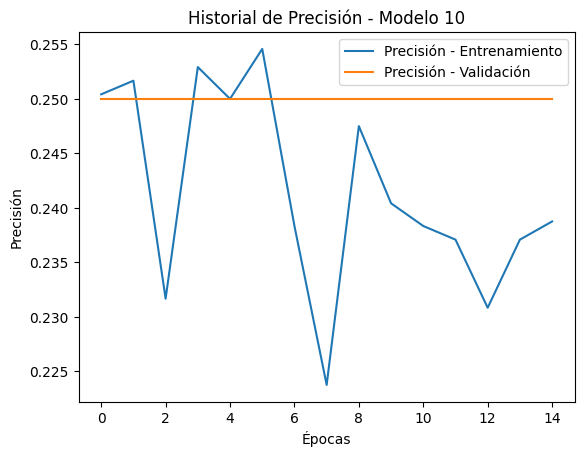

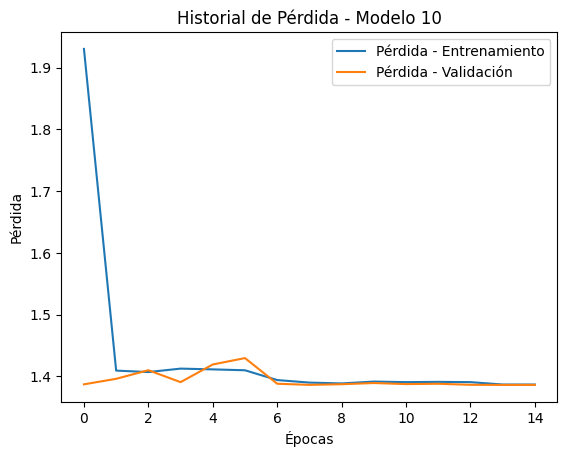


Matriz de Confusión:


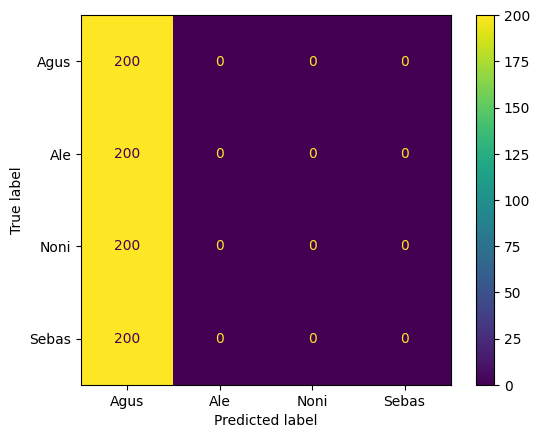

In [23]:
def mostrar_configuracion(configuracion):
    salida = []
    salida.append("Capas Ocultas:")
    for i, capa in enumerate(configuracion["capas_ocultas"]):
        salida.append(f"  Capa {i + 1}: {capa['neuronas']} neuronas, activación='{capa['activation']}', dropout={capa.get('dropout', 0)}")
    salida.append(f"Learning Rate: {configuracion['learning_rate']}")
    salida.append(f"Factor de Reducción: {configuracion['factor_reduccion']}")
    salida.append(f"Salida: {configuracion['output']['neuronas']} neuronas, activación='{configuracion['output']['activation']}'")
    return "\n".join(salida)

def mostrar_todo_dataframe(df, labels):
    for index, fila in df.iterrows():
        print(f"Modelo {index + 1}:")
        print("-" * 40)
        
        print("Configuración del modelo:")
        print(mostrar_configuracion(fila["configuracion"]))
        
        print("\nMétricas del modelo:")
        print(f"Precisión: {fila['precision']:.4f}")
        print(f"Recall: {fila['recall']:.4f}")
        
        historial = fila["historial"]
        print("\nGraficando historial de entrenamiento...")
        plt.plot(historial["accuracy"], label="Precisión - Entrenamiento")
        plt.plot(historial["val_accuracy"], label="Precisión - Validación")
        plt.title(f"Historial de Precisión - Modelo {index + 1}")
        plt.xlabel("Épocas")
        plt.ylabel("Precisión")
        plt.legend()
        plt.show()

        plt.plot(historial["loss"], label="Pérdida - Entrenamiento")
        plt.plot(historial["val_loss"], label="Pérdida - Validación")
        plt.title(f"Historial de Pérdida - Modelo {index + 1}")
        plt.xlabel("Épocas")
        plt.ylabel("Pérdida")
        plt.legend()
        plt.show()

        print("\nMatriz de Confusión:")
        cm_display = ConfusionMatrixDisplay(fila["matriz_confusion"], display_labels=labels)
        cm_display.plot()
        plt.show()

        print("\n" + "=" * 50 + "\n")

mostrar_todo_dataframe(df_resultados, labels=labels)
